In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy import cos
from math import log
from scipy.interpolate import interp1d
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize

Nesse modelo, foram feitas as seguintes modificações em relações aos demais:

Primeiro, foi removido $I_{H0}$ e $I_{M0}$ das equações diferenciais. 

Segundo, as equações de $\dfrac{dE_M}{dt}$ e $\dfrac{dI_M}{dt}$ foram modificadas, para que utilizem auma nova taxa, $b_3$, de modo a corrigir a transferência de mosquitos do compartimento $E$ para $I$, já que não é necessária a ocorrência de novo contato com humano infectado para a conversão de $E_M$ para $I_M$. 

In [2]:
def model(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T1 - T_curr) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M * l_curr
    dImdt = b3_curr * E_M * l_curr - mu_curr * I_M
    
#     print(dSmdt)
#     print(dEmdt)
#     print(dImdt)
#     print(' ')
    
    #print(b_curr - mu_curr*M)
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [3]:
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=317.925
B=15
C=-48.78

b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1825 
R_L = 312
N = 8558
M = 300000 
E_M0 = 50000
I_H0 = 1000 
I_M0 = 2500
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

In [4]:
# Funções de temperatura e chuva fora do contexto da função lotkavolterra
def T(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

def R(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

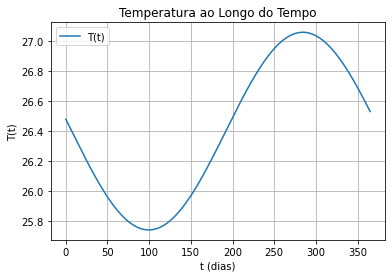

In [5]:
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
T_values = [T(t) for t in t_values]

# Plotando
plt.plot(t_values, T_values, label='T(t)')
plt.title('Temperatura ao Longo do Tempo')
plt.xlabel('t (dias)')
plt.ylabel('T(t)')
plt.legend()
plt.grid(True)
plt.show()

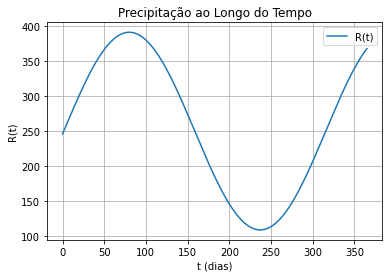

In [6]:
# Pontos no tempo
t_values = np.linspace(0, 365, 1000) # 1000 pontos entre 0 e 365
R_values = [R(t) for t in t_values]

# Plotando
plt.plot(t_values, R_values, label='R(t)')
plt.title('Precipitação ao Longo do Tempo')
plt.xlabel('t (dias)')
plt.ylabel('R(t)')
plt.legend()
plt.grid(True)
plt.show()

Analisando a modelagem de humanos com dados originais, é possível ver que o modelo fica de forma bem diferente do que era utilizando $I_{H0}$ e $I_{M0}$ nas EDOs, em especial na modelagem de humanos.

In [7]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

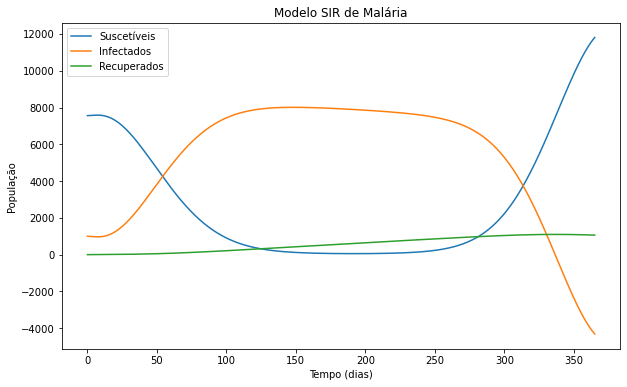

In [8]:
t_eval = np.linspace(0, 365, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 365], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

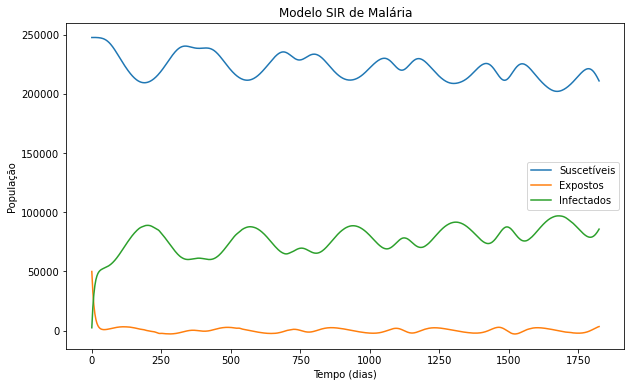

In [9]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Modificando $A, \ B$ e $C$:

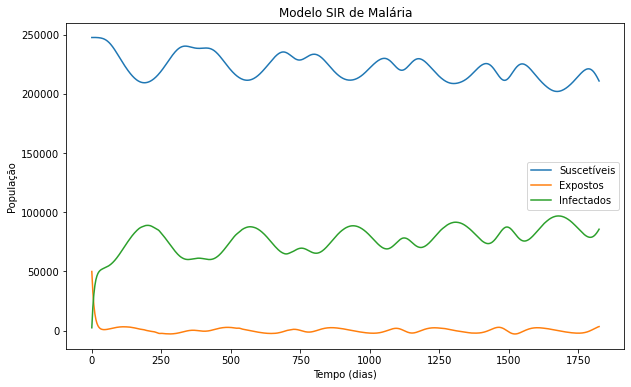

In [10]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 298.5, 11.7, -48, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Testando efeito de $A$ muito grande:

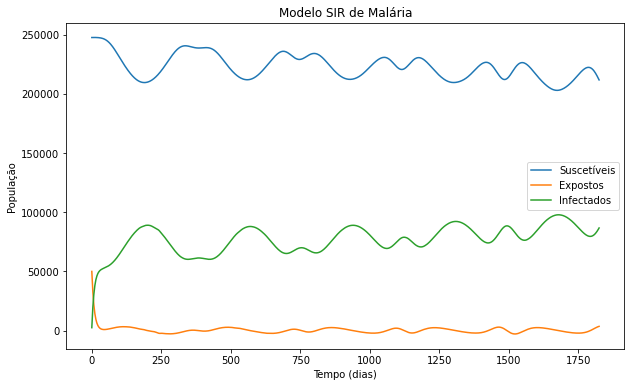

In [11]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 1298.5, 11.7, -48, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Aumentar $A$ não parece modificar muito o equilíbrio de mosquitos.

Testando efeito de $A$ muito pequeno:

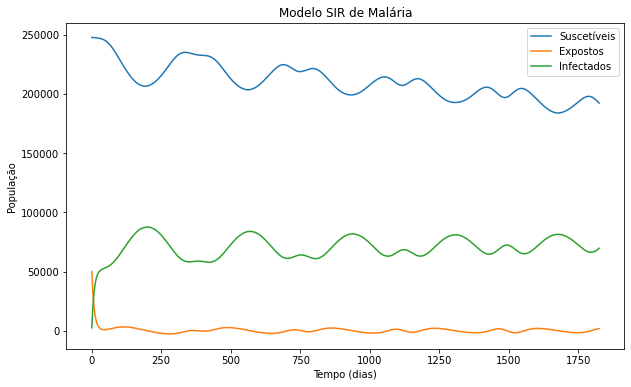

In [12]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 18.5, 11.7, -48, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

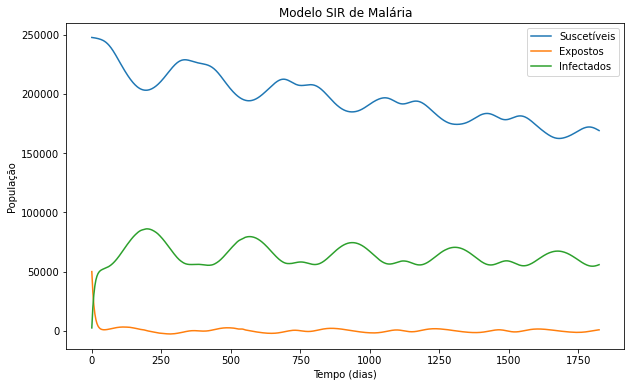

In [13]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, 8.5, 11.7, -48, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [14]:
min(I_M)

2500.0

Diminuir $A$ fará com que a população diminua ao longo do tempo. O número de infectados acaba ficando negativo

In [15]:
A

317.925000000000

In [16]:
B

15

In [17]:
C

-48.7800000000000

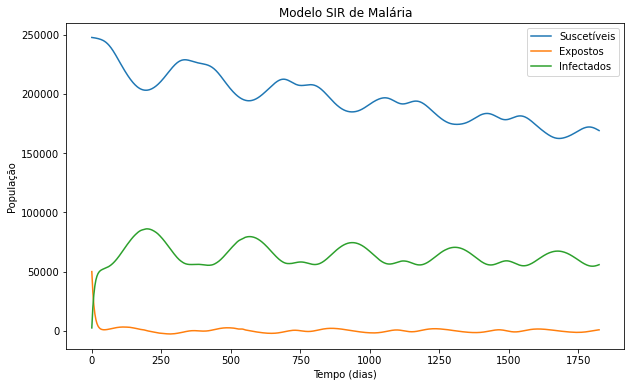

In [18]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Estimando valores de $\mu$ para diferentes $A, \ B$ e $C$:

In [19]:
# Novos valores de A, B e C
A_novo = -1000
B_novo = 10
C_novo = -50

# Função para calcular T(t) com os novos valores de A, B e C
def T_novo(t):
    return T1 * (1 + T2 * np.cos(omega1 * t - phi1))

# Calcular mu usando os novos valores de A, B, C e T(t)
def calcular_mu_novo(t):
    return 1 / (A_novo * T_novo(t)**2 + B_novo * T_novo(t) + C_novo)

# Calcular mu para o dado t usando os novos valores de A, B, C
t_valor = 0  # Vamos calcular para t = 0
mu_novo = calcular_mu_novo(t_valor)

print("Novo valor de mu para t = 0:", mu_novo)

Novo valor de mu para t = 0: -1.4266336310907504e-06


In [20]:
# Novos valores de A, B e C
A_novo = -10
B_novo = 100
C_novo = -25

# Função para calcular T(t) com os novos valores de A, B e C
def T_novo(t):
    return T1 * (1 + T2 * np.cos(omega1 * t - phi1))

# Calcular mu usando os novos valores de A, B, C e T(t)
def calcular_mu_novo(t):
    return 1 / (A_novo * T_novo(t)**2 + B_novo * T_novo(t) + C_novo)

# Calcular mu para o dado t usando os novos valores de A, B, C
t_valor = 0  # Vamos calcular para t = 0
mu_novo = calcular_mu_novo(t_valor)

print("Novo valor de mu para t = 0:", mu_novo)

Novo valor de mu para t = 0: -0.00022785775851987173


In [21]:
# Novos valores de A, B e C
A_novo = -1800.5
B_novo = 11.7
C_novo = -48

# Função para calcular T(t) com os novos valores de A, B e C
def T_novo(t):
    return T1 * (1 + T2 * np.cos(omega1 * t - phi1))

# Calcular mu usando os novos valores de A, B, C e T(t)
def calcular_mu_novo(t):
    return 1 / (A_novo * T_novo(t)**2 + B_novo * T_novo(t) + C_novo)

# Calcular mu para o dado t usando os novos valores de A, B, C
t_valor = 0  # Vamos calcular para t = 0
mu_novo = calcular_mu_novo(t_valor)

print("Novo valor de mu para t = 0:", mu_novo)

Novo valor de mu para t = 0: -7.922757156718842e-07


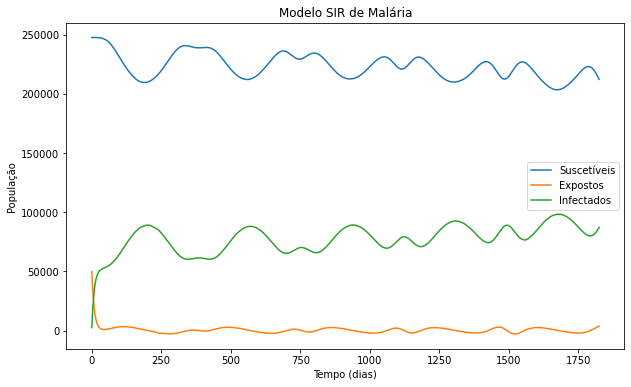

In [22]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -1800.5, 11.7, -48, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

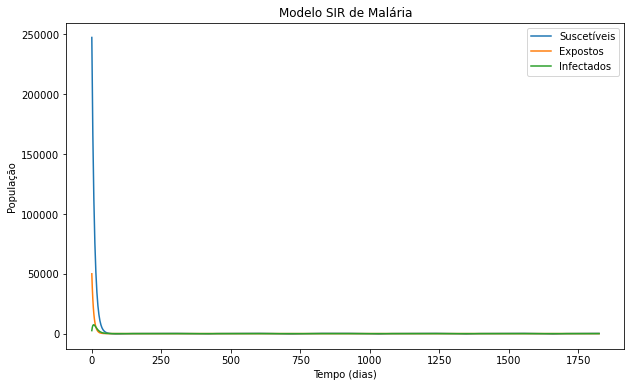

In [23]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -0.03, 1.31, -4.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [24]:
# Novos valores de A, B e C
A_novo = -0.03
B_novo = 1.31
C_novo = -4.4

# Função para calcular T(t) com os novos valores de A, B e C
def T_novo(t):
    return T1 * (1 + T2 * np.cos(omega1 * t - phi1))

# Calcular mu usando os novos valores de A, B, C e T(t)
def calcular_mu_novo(t):
    return 1 / (A_novo * T_novo(t)**2 + B_novo * T_novo(t) + C_novo)

# Calcular mu para o dado t usando os novos valores de A, B, C
t_valor = 0  # Vamos calcular para t = 0
mu_novo = calcular_mu_novo(t_valor)

print("Novo valor de mu para t = 0:", mu_novo)

Novo valor de mu para t = 0: 0.10807050518217226


Usando os valores originais de $A, \ B$ e $C$ do artigo, a população rapidamente decai, visto que a taxa de mortalidade fica com um valor positivo

In [25]:
# Novos valores de A, B e C
A_novo = -0.3
B_novo = 1.31
C_novo = -4.4

# Função para calcular T(t) com os novos valores de A, B e C
def T_novo(t):
    return T1 * (1 + T2 * np.cos(omega1 * t - phi1))

# Calcular mu usando os novos valores de A, B, C e T(t)
def calcular_mu_novo(t):
    return 1 / (A_novo * T_novo(t)**2 + B_novo * T_novo(t) + C_novo)

# Calcular mu para o dado t usando os novos valores de A, B, C
t_valor = 0  # Vamos calcular para t = 0
mu_novo = calcular_mu_novo(t_valor)

print("Novo valor de mu para t = 0:", mu_novo)

Novo valor de mu para t = 0: -0.005553658208357254


In [26]:
# CÓDIGO QUEBRADO

# args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
#                    B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
#                    D1, b1, -0.3, 1.31, -4.4, b2, tau_H, DD, Tmin, gamma, R_L,
#                    N, M, E_M0, I_H0, I_M0)

# t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
# sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_M, label='Suscetíveis')
# plt.plot(times, E_M, label='Expostos')
# plt.plot(times, I_M, label='Infectados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

Diminuir $A$ de -0.03 para -0.3 parece ter quebrado a modelagem, inclusive visto que o modelo parou em $t=800$, e não foi até $t=1825$.

In [27]:
# Novos valores de A, B e C
A_novo = -3
B_novo = 1.31
C_novo = -4.4

# Função para calcular T(t) com os novos valores de A, B e C
def T_novo(t):
    return T1 * (1 + T2 * np.cos(omega1 * t - phi1))

# Calcular mu usando os novos valores de A, B, C e T(t)
def calcular_mu_novo(t):
    return 1 / (A_novo * T_novo(t)**2 + B_novo * T_novo(t) + C_novo)

# Calcular mu para o dado t usando os novos valores de A, B, C
t_valor = 0  # Vamos calcular para t = 0
mu_novo = calcular_mu_novo(t_valor)

print("Novo valor de mu para t = 0:", mu_novo)

Novo valor de mu para t = 0: -0.00048234412357854264


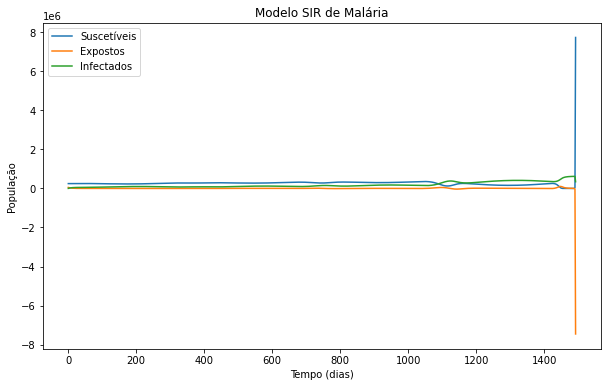

In [28]:
args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -3, 1.31, -4.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

Notavelmente, uma taxa negativa de $\mu$ fará com que a população de mosquitos aumente. Ainda assim, pode-se notar que a população de msoquitos infectados costuma flutuar sempre de forma próxima, ocasionalmente ficando negativa.

In [29]:
I_M0

2500

In [30]:
E_M0

50000

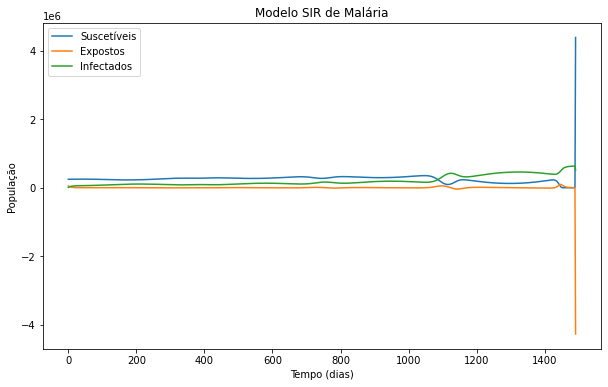

In [31]:
I_M0 = 10000

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, -3, 1.31, -4.4, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [32]:
print(f'A={A}, B={B}, C={C}')

A=317.925000000000, B=15, C=-48.7800000000000


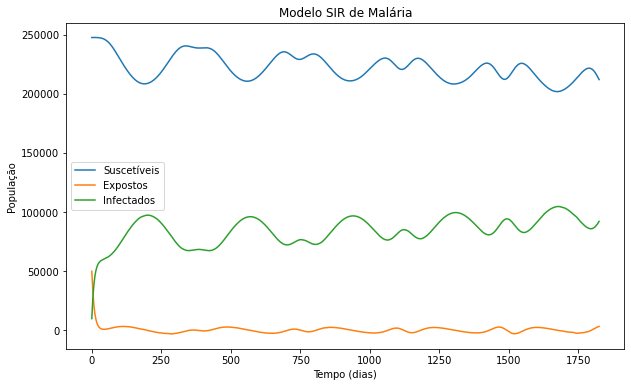

In [33]:
I_M0 = 10000

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [34]:
min(I_M)

10000.0

In [35]:
def model(t, z, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T1 - T_curr) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M * l_curr
    dImdt = b3_curr * E_M * l_curr - mu_curr * I_M
    
    print(a_curr)
    print(b3_curr)
    print(E_M)
    print(l_curr)
    print(' ')
    print(- mu_curr * I_M)
    
#     print(dSmdt)
#     print(dEmdt)
    print(dImdt)
    print(' ')
    
    #print(b_curr - mu_curr*M)
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

-0.0021789541858209358
0.11409077931221394
50000.0
0.9999607429747496
 
-0.22394762600268425
5704.091074754479
 
-0.002178941732893236
0.11409077498333905
49999.76695070923
0.9999607429719134
 
-0.2239486762685454
5704.06426952239
 
-0.0021788886832203075
0.11409075654226228
49998.77415718914
0.999960742959831
 
-0.2239531504186466
5703.950078848763
 
-0.0021788559319093352
0.11409074515728276
49998.1612698872
0.9999607429523716
 
-0.22395591247486982
5703.879584807546
 
-0.002178806804929104
0.11409072807980866
49997.241930407
0.9999607429411826
 
-0.2239600555982637
5703.773842798762
 
-0.0021786034491378657
0.1140906573894622
49993.43660924527
0.9999607428948661
 
-0.22397720479830627
5703.33615665237
 
-0.0021785390876671194
0.11409063501618903
49992.23229897073
0.9999607428802065
 
-0.22398263219632292
5703.197637538424
 
-0.002178642862314637
0.11409067109023317
49994.1741101082
0.9999607429038424
 
-0.22397388115077058
5703.420983614166
 
-0.0021785710183355907
0.114090646115897

0.999963661650073
 
-0.5723671998151804
-271.046632264369
 
-0.017019594042655444
0.11924966840530403
-2566.485739335316
0.9999639310067071
 
-0.5575429804544496
-306.59907735491583
 
-0.017119477905133934
0.11928438993845131
-2587.977131716054
0.9999639512271496
 
-0.5560614349477849
-309.25020632008426
 
-0.01726029364055957
0.11933334017028975
-2621.9361979270884
0.9999639797071601
 
-0.5538745959586749
-313.42700862012333
 
-0.017726471100625325
0.11949539233497926
-2740.4300492323805
0.999964073769584
 
-0.54473595285709
-328.001735134181
 
-0.017834305205575066
0.11953287752384276
-2775.217295850499
0.9999640954792304
 
-0.5418477094936195
-332.25964624021015
 
-0.01765095120352811
0.11946914018027405
-2721.8747671967926
0.9999640585547543
 
-0.54652285832603
-325.71487353317553
 
-0.017783214330069845
0.11951511736235759
-2759.7247443532156
0.9999640851956509
 
-0.5432872729421377
-330.36026824433907
 
-0.018070029975836562
0.11961481994398128
-2891.8064679356567
0.9999641428731

 
-0.016397514542473006
0.11903342172190728
-2128.458982927368
0.9999638047189117
 
-0.5623217446056034
-253.91090712199625
 
-0.01679442771653104
0.11917139630146079
-2227.4847005559586
0.9999638853664787
 
-0.5581838843137651
-266.001059171326
 
-0.016129525086198717
0.11894026348234527
-2099.70570185589
0.9999637501258098
 
-0.5649947563583989
-250.29549114323405
 
-0.016603884002264216
0.11910515967697755
-2190.6757160942097
0.9999638466815864
 
-0.5602946435615378
-261.4716424573645
 
-0.018068568699285695
0.11961431197641835
-2528.053485569969
0.9999641425796378
 
-0.5317916156931044
-302.91232695696505
 
-0.018002706665122437
0.11959141707882827
-2507.42475140859
0.99996412934624
 
-0.5360343529934758
-300.3917571858244
 
-0.017783945391325627
0.11951537149317508
-2520.2337569000824
0.9999640853428284
 
-0.5155676291510746
-301.7114236002808
 
-0.017076840373257993
0.11926956832022777
-1419.122347376073
0.999963942597549
 
-0.5013165047289074
-169.75332326207956
 
-0.01707684037

0.013341516781147244
0.10869556797607736
2264.173856272971
0.9999569744296007
 
-0.6127192459341811
245.4823552216996
 
0.012824041777264483
0.10887545214409376
2190.957051903412
0.9999571080211734
 
-0.6145773725415272
237.91663076735423
 
0.009318408720457215
0.11009407696860295
1685.0526783303133
0.999957998009966
 
-0.622841128306894
184.88368616535226
 
0.009883169395127227
0.10989775540074148
1766.8515561941683
0.9999578563795503
 
-0.6219213684481115
193.54291562953517
 
0.006931892914955508
0.11092367532003926
1345.0416000010005
0.9999585892442162
 
-0.6253847711223989
148.5653946005544
 
0.005183446717298107
0.11153146852208207
1107.600655351455
0.9999590150806351
 
-0.6260368632025813
122.90122780167893
 
0.005183446717298107
0.11153146852208207
1098.9727472497118
0.9999590150806351
 
-0.6260783614762364
121.93894248164615
 
0.01497524773056211
0.10812765197937602
2493.5023783392066
0.9999565488426629
 
-0.605177829955203
268.9996643933977
 
0.014802365699433597
0.10818774906

-661.2099297973662
0.9999569198984083
 
-0.5431501934768624
-72.36224164028134
 
0.014388255105107155
0.10833170179679608
-235.96617818146603
0.9999567024263009
 
-0.543418335468117
-26.104929185030752
 
0.01463716173212494
0.10824517711216607
-106.42794511624311
0.9999566373936266
 
-0.5436968635044956
-12.063509081551592
 
0.014232039524495841
0.10838600530815143
-324.6689772112654
0.9999567431719127
 
-0.5433162897003109
-35.73136758778182
 
0.014514641812424981
0.10828776736996654
-173.87508981259248
0.9999566694218078
 
-0.5435572223704175
-19.371286647675095
 
0.015992204198036226
0.10777413854068263
723.6466486121075
0.9999562809596863
 
-0.547055785277737
77.43992871155777
 
0.015794778360440388
0.1078427675223231
594.0084303683612
0.9999563331444976
 
-0.5463129622482638
63.51040282276651
 
0.016699348174528703
0.10752832182504478
1193.350923715056
0.9999560933284382
 
-0.5508027778652906
127.76258533641992
 
0.01710749647066313
0.1073864417030552
1489.8025287294863
0.99995598

-276.38493921889864
 
0.00915205628804102
0.1101519042427286
-2562.31048864387
0.9999580396014691
 
-0.5801294416221202
-282.8116659821707
 
0.008320659136731752
0.11044091372865991
-2489.175576188214
0.9999582466112542
 
-0.5827369351499693
-275.478083708904
 
0.008898825425559722
0.11023993211397208
-2550.4642995527133
0.9999581028044228
 
-0.580948519389081
-281.7321798195185
 
0.012073379643895852
0.10913639659997904
-1984.6625116464857
0.9999573007880257
 
-0.5703073126416447
-217.15997369781851
 
0.011632035519381963
0.10928981622421481
-2152.3470742287536
0.9999574135606951
 
-0.571686992514032
-235.79128559392825
 
0.013713653378654926
0.10856620620646756
-1226.4517194532248
0.9999568780002643
 
-0.5669175963033533
-133.7123861262845
 
0.014717901972103832
0.1082171102668401
-700.0921846636909
0.9999566162691288
 
-0.5659897421033253
-76.32465605062143
 
0.014717901972103832
0.1082171102668401
-564.5485329886471
0.9999566162691288
 
-0.5658536215401836
-61.65701398950781
 
0.00

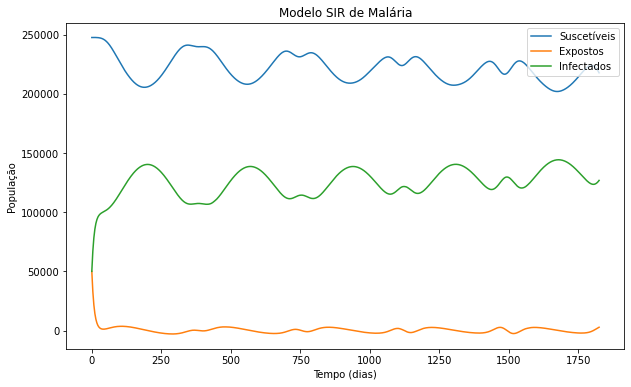

In [36]:
I_M0 = 50000

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

-0.0021789541858209358
0.11409077931221394
50000.0
0.9999607429747496
 
-0.08957905040107371
5704.225443330081
 
-0.002178941732894696
0.11409077498333957
49999.766950736856
0.9999607429719134
 
-0.08958009608170422
5704.198638105754
 
-0.0021788886832281914
0.11409075654226503
49998.77415733449
0.999960742959831
 
-0.0895845506981904
5704.084447465202
 
-0.002178855931920918
0.11409074515728679
49998.16127009956
0.9999607429523716
 
-0.08958730069499085
5704.013953443755
 
-0.0021788068049464295
0.1140907280798147
49997.2419307213
0.9999607429411826
 
-0.08959142572925063
5703.908211464791
 
-0.002178603449179525
0.11409065738947669
49993.43660995139
0.9999607428948661
 
-0.08960850004821312
5703.470525438404
 
-0.0021785390877162732
0.11409063501620612
49992.23229979076
0.9999607428802065
 
-0.08961390374481137
5703.332006361284
 
-0.002178642862351624
0.11409067109024602
49994.17411074217
0.9999607429038424
 
-0.0896051909117339
5703.555352377374
 
-0.002178571018381046
0.1140906461

 
-0.015950897937482965
0.11887816928302979
-2173.3143445146848
0.9999637136736523
 
-0.3540633900885778
-258.7043190206729
 
-0.01427221667240343
0.11829462770040688
-1635.5847832411011
0.9999633686131861
 
-0.3457633685599462
-193.8195689010839
 
-0.013156699451099731
0.11790685266633466
-1296.2992375675794
0.9999631367944134
 
-0.3426642529353228
-153.17959320146767
 
-0.013156699451099731
0.11790685266633466
-1287.7093898479027
0.9999631367944134
 
-0.3426148155178305
-152.16677918966502
 
-0.01785556101486412
0.11954026644802418
-2751.371501899771
0.999964099756401
 
-0.3774407562949907
-329.2653156121751
 
-0.017626908492371467
0.1194607824759196
-2687.7059563717194
0.999964053709048
 
-0.37221314986624493
-321.4361282914407
 
-0.014837117781361736
0.11849099808590192
-1797.0132667028224
0.9999634852367646
 
-0.3479025350853335
-213.27002299558825
 
-0.012453596969565344
0.11766244085132509
-1079.245149774909
0.9999629896349377
 
-0.34112172293241705
-127.32304050128973
 
-0.0120

-0.017863322677423694
0.11954296454977109
-2414.433947997706
0.999964101318055
 
-0.4046884325325879
-289.02291889976703
 
-0.017904733337577465
0.11955735968401501
-2418.439363510276
0.9999641096483303
 
-0.4034998959456233
-289.5353473369913
 
-0.017958747115142667
0.11957613590193054
-2426.039950627468
0.9999641205098574
 
-0.40173791790830576
-290.48781224375483
 
-0.01807840267066664
0.1196177304521841
-2429.637850342877
0.9999641445549589
 
-0.3945138057017023
-291.0118586965674
 
-0.01808127829141336
0.1196187300727294
-2424.5982735197936
0.9999641451325477
 
-0.3922815377152998
-290.4092490599048
 
-0.01806832591435919
0.11961422757975342
-2433.7894382680397
0.9999641425308683
 
-0.3959072503582923
-291.50131232317074
 
-0.01808195739293451
0.11961896614135342
-2428.701082530223
0.9999641452689482
 
-0.3933906733552208
-290.901686761702
 
-0.017729504886529465
0.11949644693674595
-2268.156909217519
0.999964074380608
 
-0.37922814842288605
-271.4061827339189
 
-0.017828994351580

0.9999638057550784
 
-0.3774122312193216
-159.38040354173654
 
-0.01640260634171894
0.11903519172831181
-1349.2535541419952
0.9999638057550784
 
-0.37745811145208913
-160.98030050983667
 
-0.017419255427263636
0.11938859831519164
-2144.79172576901
0.9999640118197775
 
-0.4189854661631741
-256.47344801796044
 
-0.017745871753077316
0.11950213637130783
-2183.8093041191078
0.9999640776767516
 
-0.4134751633210215
-261.3739777888041
 
-0.017474030207744826
0.11940763907221605
-1737.8067233183142
0.9999640228759028
 
-0.3844081078816246
-207.88434058373656
 
-0.016063846151320383
0.11891743223355421
-1198.5564095972966
0.9999637367287136
 
-0.3760653741750004
-142.90014741367222
 
-0.015883509559825714
0.11885474379936797
-1108.5027908531465
0.9999636999086199
 
-0.37559887720281826
-132.1216315183065
 
-0.015599537684078756
0.11875602976637023
-975.9362610280509
0.9999636418237952
 
-0.37488858811857617
-116.26899040146307
 
-0.014258417429165527
0.11828983082061467
-352.3956155541425
0.99

0.9999638879812491
 
-0.39470416354134574
-156.1452201406632
 
-0.016231927035054917
0.11897586035028097
-1897.1659262199787
0.9999637709999392
 
-0.4438887418741428
-226.15265954180012
 
-0.016382901483500936
0.11902834194426459
-1915.9126187679983
0.9999638017449699
 
-0.4425659288126141
-228.48221331473403
 
-0.016597869781053157
0.11910306901912798
-1945.4574778983122
0.9999638454596225
 
-0.4406196847904215
-232.1421985817221
 
-0.017337492084594567
0.11936017581988285
-2039.8036648166462
0.9999639953073353
 
-0.4324885353350656
-243.8950464956955
 
-0.017520023365176114
0.1194236271697993
-2065.2901611160723
0.9999640321558505
 
-0.42993806315482075
-247.06550899287802
 
-0.017213348446232495
0.11931702112654748
-2027.526801546628
0.9999639702159488
 
-0.43408089392034627
-242.3438228388931
 
-0.017432610626652446
0.11939324083688392
-2055.0646894808797
0.9999640145159187
 
-0.4312117589277413
-245.78321573712972
 
-0.01807978003718814
0.11961820925102254
-2064.936520755828
0.999

 
-0.010345738051368732
0.11692970894166627
-1066.081983217853
0.9999625435485648
 
-0.49488754880310476
-125.14687435843923
 
-0.008966005625380703
0.11645008766977517
-869.8203052819731
0.9999622475096955
 
-0.49938294433312214
-101.78620977705697
 
-0.009929677619140875
0.11678507841046323
-1007.0542106711099
0.9999624546176281
 
-0.4963145116107945
-118.10080379711658
 
-0.014747299989716831
0.11845977571071108
-1707.842793149806
0.9999634667283532
 
-0.4746180592207421
-202.7779012140826
 
-0.014143284790612233
0.11824980852245091
-1620.400902290184
0.9999633419229264
 
-0.47817153324195827
-192.08324382766386
 
-0.01669693805638563
0.11913750703864832
-1999.1984084803003
0.9999638655809334
 
-0.4597325652510958
-238.63064054883876
 
-0.017567582065324702
0.11944015947985094
-1644.6281840433564
0.9999640417481882
 
-0.4470919792545391
-196.87468111974837
 
-0.017567582065324702
0.11944015947985094
-2190.2798197940256
0.9999640417481882
 
-0.4494249956158537
-262.0473890335919
 
-0

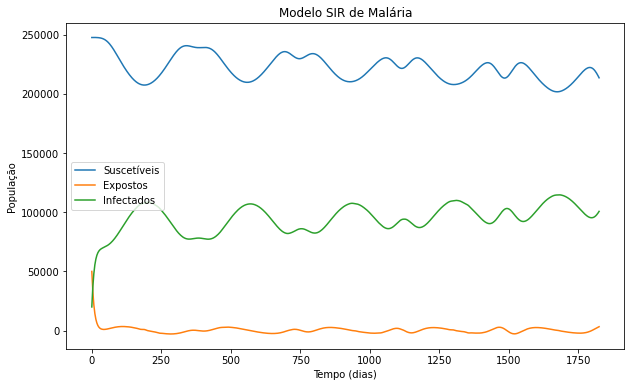

In [37]:
I_M0 = 20000

args = (T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [38]:
min(I_M)

20000.0

In [39]:
I_M[0]

20000.0

In [40]:
I_M[-1]

100704.77255010055

In [41]:
def T(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))
    
T0 = T(0)
T0

26.479531827782463

In [42]:
M = 300000
a0 = (T1 - T0) / D1
b1 = 0.1
b2 = 0.3
p0 = np.exp(-1 / (A*T0**2 + B*T0 + C))
tau_M0 = DD / (T0 - Tmin)
l0 = p0**tau_M0
gamma = 1/1825
mu0 = -log(p0)
N = 8558

In [43]:
R0 = (M*(a0**2)*b1*b2*l0)/(gamma*mu0*N)
R0

2034.397370927539

Analisando o artigo original, foi notado que existem dois $T_1$ distintos, um usado no cálculo de $a(T)$ e um na equação de $T(t)$ em si. Para isso, o $T_1$ de $a(T)$ foi chamado de $T'$. Como estava sendo usado o mesmo valor de $T_1$ para ambos, foi verificado como aumentar ou diminuir esse valor para $T'$ afeta o modelo.

In [44]:
def model(t, z, T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0):
    
    S_H, I_H, R_H, S_M, E_M, I_M = z
    
    # Funções de temperatura e chuva
    def Temp(t):
        return T1 * (1 + T2 * cos(omega1 * t - phi1))

    def Rain(t):
        return R1 * (1 + R2 * cos(omega2 * t - phi2))

    R_curr = Rain(t)
    T_curr = Temp(t)
    
    # Duração da fase de desenvolvimento das larvas
    def tau_L(Temp):
        return 1 / (c1 * Temp + c2)
    
    # Taxa diária de sobrevivência dos mosquitos
    def p(Temp):
        return np.exp(-1 / (A*Temp**2 + B*Temp + C))
    
    # Probabilidade de sobrevivência das larvas dependente de temperatura e chuva
    def p_LT(Temp):
        return np.exp(-(c1 * Temp + c2))
    
    def p_LR(Rain):
        return (4*p_ML/R_L**2) * Rain * (R_L - Rain)
    
    def p_LRT(Rain,Temp):
        return p_LR(Rain)*p_LT(Temp)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_ER(Rain):
        return (4*p_ME/R_L**2) * Rain * (R_L - Rain)
    
    # Probabilidade de sobrevivência dos ovos e pupas dependente de chuva (Não definido previamente)
    def p_PR(Rain):
        return (4*p_MP/R_L**2) * Rain * (R_L - Rain)

    # Duração do ciclo esporogônico
    def tau_M(Temp):
        return DD / (Temp - Tmin)
    
    tau_M_curr = tau_M(T_curr)

    # Taxa de infecção de expostos (1/Duração do ciclo esporogônico)
    def b3(tau_M, Temp):
        return 1/tau_M
    
    b3_curr = b3(tau_M_curr, T_curr)
    
    # Definindo a função de sobrevivência do mosquito
    def l_tau_M(tau_M, Temp):  
        p_T = p(Temp)
        return p_T**tau_M
    
    l_curr = l_tau_M(tau_M_curr, T_curr)

    # Definindo a taxa de mortalidade do mosquito
    def mu(Temp):
        return -log(p(Temp))
    
    mu_curr = mu(T_curr)
    
    # Calcula a taxa de mordida e probabilidade de transmissão
    def a(Temp):
        return (T_linha - T_curr) / D1
    
    a_curr = a(T_curr)
    
    def b(Rain,Temp):
        return B_E * p_ER(R_curr) * p_LRT(R_curr,T_curr) * p_PR(R_curr) / (tau_E + tau_L(T_curr) + tau_P)
    
    b_curr = b(R_curr, T_curr)
    
    dShdt = -a_curr * b2 * (I_M / N) * S_H
    dIhdt = a_curr * b2 * (I_M / N) * S_H - gamma * I_H
    dRhdt = gamma * I_H
    
    dSmdt = b_curr - a_curr * b1 * (I_H / N) * S_M - mu_curr * S_M
    dEmdt = a_curr * b1 * (I_H / N) * S_M - mu_curr * E_M - b3_curr * E_M * l_curr
    dImdt = b3_curr * E_M * l_curr - mu_curr * I_M
    
#     print(dSmdt)
#     print(dEmdt)
#     print(dImdt)
#     print(' ')
    
    #print(b_curr - mu_curr*M)
    
    return [dShdt, dIhdt, dRhdt, dSmdt, dEmdt, dImdt] 

In [45]:
T_linha = 28
T1= 26.4 
T2= 0.025
omega1= 0.017
phi1= -1.45

R1= 250.083 
R2= 0.565
omega2= 0.02
phi2=1.6

B_E=200
p_ME=0.9
p_ML=0.75
p_MP=0.85
tau_E=1
tau_P=1
c1=0.019
c2=-0.021

D1=36.5
b1=0.1

A=317.925
B=15
C=-48.78

b2=0.3
tau_H=10
DD=105
Tmin=14.5
gamma= 1/1825 
R_L = 312
N = 8558
M = 300000 
E_M0 = 50000
I_H0 = 1000 
I_M0 = 2500
if E_M0 is None:
        E_M0 = M / 100

S_H0 = N - I_H0
S_M0 = M - E_M0 - I_M0

In [46]:
args = (T_linha, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

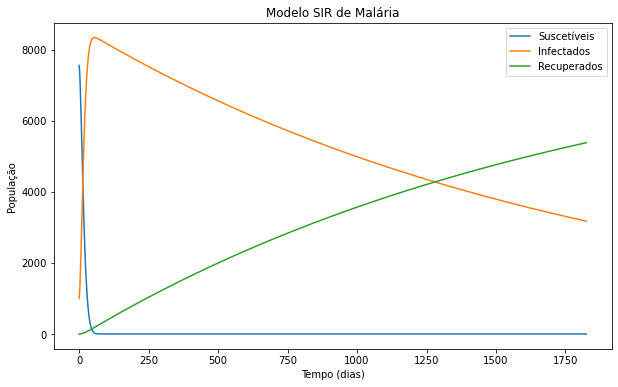

In [47]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [48]:
args = (26, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

In [49]:
# CÓDIGO QUEBRADO

# t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
# sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_H, label='Suscetíveis')
# plt.plot(times, I_H, label='Infectados')
# plt.plot(times, R_H, label='Recuperados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

In [50]:
# t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
# sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
# #sol

# times = sol.t
# S_H, I_H, R_H, S_M, E_M, I_M = sol.y

# plt.figure(figsize=(10, 6))
# plt.plot(times, S_M, label='Suscetíveis')
# plt.plot(times, E_M, label='Expostos')
# plt.plot(times, I_M, label='Infectados')

# plt.xlabel('Tempo (dias)')
# plt.ylabel('População')
# plt.title('Modelo SIR de Malária')

# plt.legend()

# plt.show()

Novamente, é possível ver que o modelo quebrou, ao parar antes de $t=1825$

In [51]:
args = (26.5, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

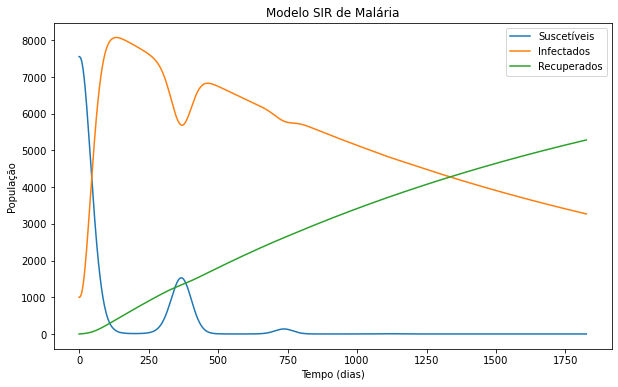

In [52]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

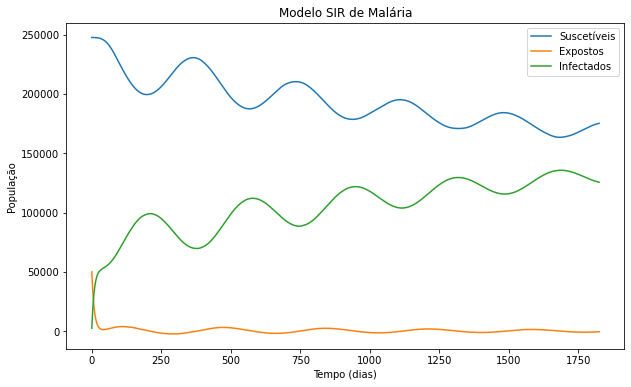

In [53]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

In [54]:
args = (26.7, T1, T2, omega1, phi1, R1, R2, omega2, phi2,
                   B_E, p_ME, p_ML, p_MP, tau_E, tau_P, c1, c2,
                   D1, b1, A, B, C, b2, tau_H, DD, Tmin, gamma, R_L,
                   N, M, E_M0, I_H0, I_M0)

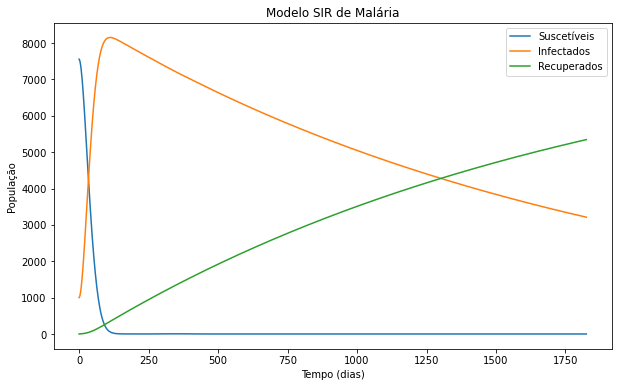

In [55]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_H, label='Suscetíveis')
plt.plot(times, I_H, label='Infectados')
plt.plot(times, R_H, label='Recuperados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()

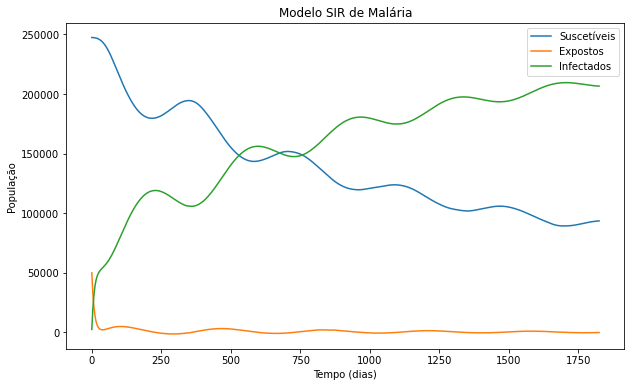

In [56]:
t_eval = np.linspace(0, 1825, 1000)  # Avalia a solução em 1000 pontos entre 0 e 1825
sol = solve_ivp(model, [0, 1825], [S_H0, I_H0, 0, S_M0, E_M0, I_M0], args=args, dense_output=True, t_eval=t_eval, method="DOP853")
#sol

times = sol.t
S_H, I_H, R_H, S_M, E_M, I_M = sol.y

plt.figure(figsize=(10, 6))
plt.plot(times, S_M, label='Suscetíveis')
plt.plot(times, E_M, label='Expostos')
plt.plot(times, I_M, label='Infectados')

plt.xlabel('Tempo (dias)')
plt.ylabel('População')
plt.title('Modelo SIR de Malária')

plt.legend()

plt.show()